<a href="https://colab.research.google.com/github/donghoon11/Hands_on_ML/blob/main/Ch7_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7.1 투표 기반 분류기

더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다.

이렇게 다수결 투표로 정해지는 분류기를 hard voting 분류기라고 한다.

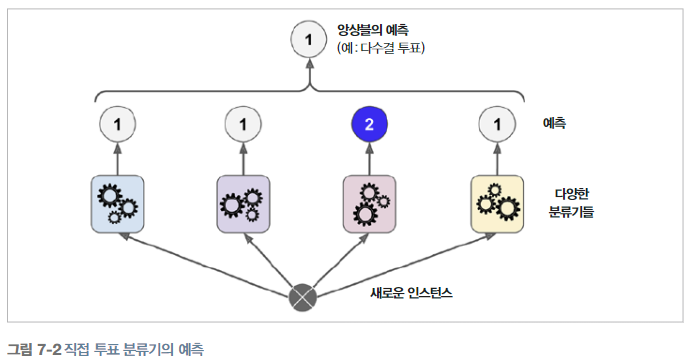

각 분류기가 weak learner 일지라도 충분하게 많고 다양하다면 앙상블은 strong learner 가 될 수도 있다.

- 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없다면, 큰 수의 법칙이 적용된다.

- 따라서 다양한 분류기를 각기 다른 알고리즘으로 학습시키면, 매우 다른 종류의 오차를 만들 가능성이 높기에 앙상블 모델의 정확도를 향상시킨다.

In [ ]:
# dataload
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris['data'][:,(2,3)]   # 꽃잎 길이, 꽃잎 너비
y = (iris['target'] == 2).astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [ ]:
# 각 분류기의 정확도를 확인해보자
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 1.0
SVC 0.9666666666666667
VotingClassifier 1.0


모든 분류기가 클래스의 확률을 예측할 수 있으면, 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 soft voting 이라고 한다. 

(SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정.)

# 7.2 배깅과 페이스팅

다양한 분류기를 만드는 또 다른 방법은 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것이다. 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 bagging 이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 pasting 이라고 한다.

앙상블의 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다. 수집 함수는 전형적으로 분류일 때는 '통계적 최빈값' 이고 회귀에 대해서는 평균을 계산한다. 

## 7.2.1 사이킷런의 배깅과 페이스팅

- 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다.

- 페이스팅 : bootstrap = False 지정.

- n_jobs : CPU 코어 수 지정

In [ ]:
# 결정 트리 분류기 500개의 앙상블을 훈련
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_train)

## 7.2.2 oob 평가

BaggingClassifier 는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다.(1-exp^(-1)=63.212%)

선택되지 않은 훈련 샘플을 oob(out-of-bag) 이라 하며 이 데이터를 검증 세트로 사용할 수 있다.

In [ ]:
bag_clf_2 = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf_2.fit(X_train, y_train)
print(bag_clf_2.oob_score_)

0.9583333333333334


In [ ]:
# 위의 모델의 테스트 데이터에 대한 예측 정확도 계산
from sklearn.metrics import accuracy_score
y_pred = bag_clf_2.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


In [ ]:
bag_clf_2.oob_decision_function_

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.32      , 0.68      ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.99557522, 0.00442478],
       [0.42167449, 0.57832551],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.12643172, 0.87356828],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.27314815, 0.72685185],
       [1.

# 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier 는 특성 샘플링도 지원한다. 샘플링은 max_features, bootstrap_features 매개변수로 조절된다.각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.

훈련 특성과 샘플을 모두 샘플링하는 것을 '랜덤 패치 방식' 이라고 한다. 

훈련 샘플을 모두 사용하고 특성은 샘플링하는 것은 '랜덤 서브스페이스 방식' 이라고 한다.

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

# 7.4 랜덤 포레스트


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 시긍로 무작위성을 더 주입한다. 이는 결국 편향을 손해보는 대신 분산을 낮춘다. 

##7.4.1 엑스트라 트리

모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소용되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

## 7.4.2 특성 중요도

- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다. 

- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다. 

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.0967889174251775
sepal width (cm) 0.023772410188238197
petal length (cm) 0.44788698251189324
petal width (cm) 0.43155168987469117


# 7.5 부스팅

부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다. 

## 7.5.1 AdaBoost

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있다. 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.

모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.

예측을 할 때 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $ { α_j}$ 를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

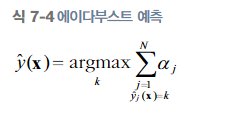

In [ ]:
# AdaBoostClassifier 기본 추정기
# from sklearn.ensemble import AdaBoostClassifier

# ada_clf = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=1), n_estimators=200,
#     algorithm='SAMME.R', learning_rate = 0.5)
# ada_clf.fit(X_train, y_train)

## 7.5.2 그레이디언트 부스팅

에이다부스트처럼 반복마다 샘프르이 가중치를 수정하는 대신 이전 예측기가 만든 residual error 에 새로운 예측기를 학습시킨다.

In [ ]:
# 간단한 2차식 형태의 데이터셋 생성
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05*np.random.randn(100)

In [ ]:
# 결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 를 훈련.
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [ ]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
# 새로운 샘플을 만들려면 모든 트리의 예측을 더하면 된다.
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

각각의 예측기를 만들지 않고, 사이킷런의 GradientBoostingRegressor를 사용할 수 있다.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)